In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
%matplotlib inline

#  class 1 : first 300,class 2: next 500, class 3: next 1000
df = pd.read_csv("./Data/Classification/NLS_Group03.txt",index_col=False, names = ["x", "y"], sep = ' ')

df_cls1 = df.iloc[:300,:]
df_cls2 = df.iloc[300:800,:]
df_cls3 = df.iloc[800:,:]

df_cls1.loc[:,"label"] = 1
df_cls2.loc[:,"label"] = 2
df_cls3.loc[:,"label"] = 3

df = pd.concat([df_cls1,df_cls2,df_cls3]).reset_index(drop=True)


df_train, df_test = skl.train_test_split(df, train_size=0.6, test_size=0.2, shuffle=True)
x_train, y_train = df_train.iloc[:,0:2], df_train.iloc[:,2]
x_test, y_test = df_test.iloc[:,0:2], df_test.iloc[:,2]

print(df.head)

<bound method NDFrame.head of              x         y  label
0    -0.380352 -0.390977      1
1    -0.416680  0.214674      1
2    -0.974757  0.263573      1
3    -1.129312 -0.387884      1
4     1.054486 -0.333915      1
...        ...       ...    ...
1795  4.221331 -0.045618      3
1796  4.483162  2.921077      3
1797 -0.524097  3.659981      3
1798 -3.563939 -4.183029      3
1799 -4.781256 -0.034948      3

[1800 rows x 3 columns]>


/tmp/ipykernel_85541/4094734383.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cls1.loc[:,"label"] = 1
/tmp/ipykernel_85541/4094734383.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cls2.loc[:,"label"] = 2
/tmp/ipykernel_85541/4094734383.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [19]:
class FCNN:
    def __init__(self,layers):
        self.layers=layers        
        self.W = []
        self.b = []
        
        for i in range(len(layers)-1):
            self.W.append(np.random.randn(layers[i+1],layers[i]))
            self.b.append(np.zeros((layers[i+1],1)))
        
        
    def logistic_fun(self,x):
        return 1.0/(1 + np.exp(-x))
    
    def logistic_deri(self,x):
        z = self.logistic_fun(x)
        return z*(1-z)
    
    def soft_max(self,x):
        denominator = 0
        for i in range(x.shape[0]):
            denominator += np.exp(x[i][0])
        
        ans = np.array(np.exp(x)/denominator)
        
        return ans
    
    def one_hot(self,Size,index):
        x = np.zeros(shape=(Size,1))
        x[index-1][0] = 1.0
        return x
        
        
    def sgd(self,df,labels,epochs,Eta):
        
        t = 1
        max_epochs = epochs
        eta = Eta
        
        while t < max_epochs:
            dw = [np.zeros(shape=i.shape) for i in self.W]
            db = [np.zeros(shape=i.shape) for i in self.b]
            eta = 1.0/t
            
            for row,label in zip(df.to_numpy(),labels):    
                x = np.array(row).reshape(row.shape[0],1)
                y = label
                
                A,H,y_hat = self.forward_propagation(x)
                
                p,q = self.backward_propagation(H,A,y_hat,x,y)
                
                self.W = [w-eta*dww for w, dww in zip(self.W, p)]
                self.b = [w-eta*dww for w, dww in zip(self.b, q)]
            
            t+=1
            
        return self.W,self.b
        
    def backward_propagation(self,H,A,y_hat,x,y):
        dw_Loss = [np.zeros(shape=i.shape) for i in self.W]
        db_Loss = [np.zeros(shape=i.shape) for i in self.b]
        
        da_Loss = (y_hat - self.one_hot(y_hat.shape[0],y))
        
        for k in range(len(self.layers)-2,-1,-1):
            dw_Loss[k] = np.dot(da_Loss,(H[k-1].T if k else x.T))
            db_Loss[k] = da_Loss
            
            if(k):
                dh = np.dot(self.W[k].T,da_Loss)
                da_Loss = dh*self.logistic_deri(A[k-1])
        
        return dw_Loss, db_Loss
        
        
        
    def forward_propagation(self,x):
        A = []
        H = []
        
        for i in range(len(self.layers)-2):
            ip = []
            if(i):
                ip = np.array(H[i-1])
            else:
                ip = np.array(x)
                
            ai = self.b[i] + np.dot(self.W[i],ip)
            A.append(ai)
            
            hi = self.logistic_fun(ai)
            H.append(hi)
        
        lst = len(self.layers)-2
        aL = self.b[lst] + np.dot(self.W[lst],H[lst-1])
        A.append(aL)
        
        y_hat = self.soft_max(aL)
        return A,H,y_hat
        
    def accuracy(self,df,labels):
        good  = 0
        for x,y in zip(df.to_numpy(),labels):
            p,q,y_hat = self.forward_propagation(x.reshape(df.iloc[0].shape[0], 1))
            good += (np.argmax(y_hat)==y-1)
            
        print("Accuracy: ",(good/len(labels))*100,"%\n")
    
    def predict(self,x):
        p,q,y_hat = self.forward_propagation(x.reshape(x.shape[0], 1))
        return np.argmax(y_hat)


In [32]:
def decision_boundary(model, df_cls1, df_cls2, df_cls3, df_test):
    fig, axes = plt.subplots()
    axes.scatter(df_cls1['x'], df_cls1['y'], label='class 1', edgecolor='k')
    axes.scatter(df_cls2['x'], df_cls2['y'], label='class 2', edgecolor='k')
    axes.scatter(df_cls3['x'], df_cls3['y'], label='class 3', edgecolor='k')

    # Extract the x and y coordinates from df_test
    x_test = df_test.iloc[:, 0]
    y_test = df_test.iloc[:, 1]

    # Define the min and max values for the grid
    x_min, x_max = x_test.min() - 1, x_test.max() + 1
    y_min, y_max = y_test.min() - 1, y_test.max() + 1

    # Create a mesh grid for plotting
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Flatten the grid and make predictions
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([model.predict(point) + 1 for point in grid_points])

    # Reshape the predictions to match the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    axes.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

    # Plot the test points
    scatter = axes.scatter(x_test, y_test, c=df_test['label'], cmap='viridis', edgecolor='k', label='Test Points')

    plt.colorbar(scatter, ax=axes)
    plt.title('Decision Boundary and Test Points')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()


In [27]:
model = FCNN([2,8,8,8,3])
W,b = model.sgd(x_train,y_train,200,0.01)
# print(W,b)

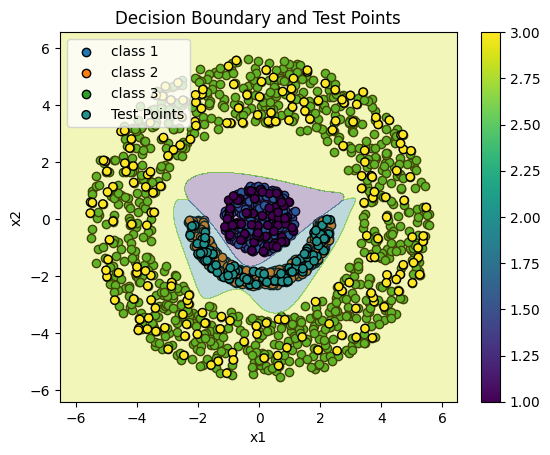

In [33]:
decision_boundary(model, df_cls1, df_cls2, df_cls3, df_test)

In [ ]:
.